In [78]:
import numpy as np
import astropy.cosmology as cosmology
import scipy.optimize as spo
import scipy.stats as sps
from scipy.stats import norm
import scipy.linalg as la
import scipy as sp
import emcee
#import corner
from datetime import datetime
import hickle
import bisect
import daft
import cProfile
from io import StringIO
import pstats
import sys
import pylab as pl
epsilon = sys.float_info.min
log_epsilon = sys.float_info.min_exp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
colors = 'rbgcymk'
import h5py
h5py.run_tests()

.....................................................x.........................s.........................................x....................................s........ss...................................................................................................ssssss.................................................................x....x........................x.....x................................................ssss...........
----------------------------------------------------------------------
Ran 439 tests in 3.545s

OK (skipped=14, expected failures=6)


<unittest.runner.TextTestResult run=439 errors=0 failures=0>

In [79]:
hickle.load_dataset
with open('data/data.hkl', 'r+') as in_file:
    sim_info = hickle.load(in_file)
    
print('all keys in data: ')
print(sim_info.keys())

types = sim_info['types']
n_types = len(types)
print('n_types: ', n_types)

z_bins = sim_info['z_bins']
z_difs = z_bins[1:] - z_bins[:-1]
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.
n_zs = len(z_difs)

print('n_zs: ', n_zs)

mu_bins = sim_info['mu_bins']
mu_difs = mu_bins[1:] - mu_bins[:-1]
print(z_bins)
print(z_difs)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.
n_mus = len(mu_difs)
print('n_mus: ', n_mus)

ln_int_post = sim_info.get('interim ln posteriors')
num_sne = np.shape(ln_int_post)[0]

print(np.shape(ln_int_post), 'shape post')
print('num_sne: ', num_sne)
def safe_log(arr, threshold=epsilon):
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

all keys in data: 
dict_keys(['host interim ln prior', 'interim ln posteriors', 'interim ln prior', 'ln host selection function', 'ln prior info', 'ln selection function', 'ln sn selection function', 'mu_bins', 'sn interim ln prior', 'types', 'z_bins'])
n_types:  3
n_zs:  100
[ 0.2    0.204  0.208  0.212  0.216  0.22   0.224  0.228  0.232  0.236
  0.24   0.244  0.248  0.252  0.256  0.26   0.264  0.268  0.272  0.276
  0.28   0.284  0.288  0.292  0.296  0.3    0.304  0.308  0.312  0.316
  0.32   0.324  0.328  0.332  0.336  0.34   0.344  0.348  0.352  0.356
  0.36   0.364  0.368  0.372  0.376  0.38   0.384  0.388  0.392  0.396  0.4
  0.404  0.408  0.412  0.416  0.42   0.424  0.428  0.432  0.436  0.44
  0.444  0.448  0.452  0.456  0.46   0.464  0.468  0.472  0.476  0.48
  0.484  0.488  0.492  0.496  0.5    0.504  0.508  0.512  0.516  0.52
  0.524  0.528  0.532  0.536  0.54   0.544  0.548  0.552  0.556  0.56
  0.564  0.568  0.572  0.576  0.58   0.584  0.588  0.592  0.596  0.6  ]
[ 0.004  0.

## Integrating over both mu and z to get P(type)

In [80]:
type_tmp=np.zeros((num_sne,3))

# Making sure to convert to posterior (not log post) and then do simple integral. This should be improved later
# scipy.integrate.simps(y, x=None, dx=1, axis=-1, even='avg')

#for zi in range(1,n_zs):
#    for mui in range(1,n_mus):
        
type_tmp[:,:] =np.dot(np.dot(np.exp(ln_int_post[:,:,:,:]),mu_difs), z_difs)
        
        #*(z_bins[zi]-z_bins[zi-1])*(mu_bins[mui]-mu_bins[mui-1])


# Ensure that the probabilities are normalised
norm = np.sum(type_tmp, axis=1)
type_tmp[:,0]=type_tmp[:,0]/norm
type_tmp[:,1]=type_tmp[:,1]/norm
type_tmp[:,2]=type_tmp[:,2]/norm


## Now we assign the true type by the highest probability.

In [81]:
true_type = np.argmax(type_tmp, axis=1)# Planck 2015 results XIV. Dark energy and modified gravity - Figure 3

true_H0 = 67.9
true_Ode0 = 0.693
true_Om0 = 1. - true_Ode0
true_w0 = -1.09
true_wa = -0.20
true_hyperparams = np.array([true_w0, true_wa])
n_hyperparams = len(true_hyperparams)
#true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)
true_cosmo = cosmology.w0waCDM(true_H0, true_Om0, true_Ode0, w0=true_w0, wa=true_wa)

#for n in range(num_sne):
#    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value

In [15]:
a = np.array([[10, 7, 4], [3, 2, 1]])
print(a)
print(np.percentile(a, 50, axis=0))
print(np.percentile(a, 50, axis=1))

[[10  7  4]
 [ 3  2  1]]
[ 6.5  4.5  2.5]
[ 7.  2.]


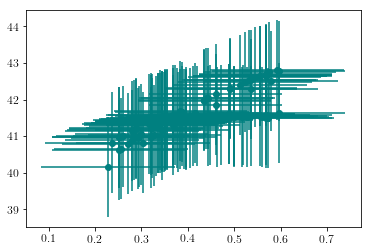

In [88]:
mumed = mumedia=np.zeros(num_sne)
mulow = mulowia=np.zeros(num_sne)
zhigh = zhighia=np.zeros(num_sne)
zlow = zlowia=np.zeros(num_sne)
muhigh = muhighia=np.zeros(num_sne)
zmed = zmedia=np.zeros(num_sne)
from scipy.interpolate import interp1d

pmin, pmax = log_epsilon, np.log(1./(min(z_difs) * min(mu_difs)))

for sn in range(num_sne):
    
    #pl.imshow(ln_int_post[sn,true_type[sn],:,:])
    
    #plt.colorbar()
    #pl.show()
    #pl.figure()
    #plt.pcolormesh(z_bins, mu_bins, ln_int_post[sn,true_type[sn],:,:].T, cmap='viridis', vmin = pmin, vmax = pmax)

    # True type
    #print(true_type[sn])
    
    hm = ln_int_post[sn,true_type[sn],:,:].T
    #print(np.shape(hm), np.shape(z_difs))
    mu_prob =np.dot(np.exp(hm),z_difs)
    muspline = interp1d(mu_prob, mu_bins[:-1])
    indsmu=np.argsort(mu_prob)
    
    #print(np.shape(mu_prob), np.shape(mu_bins))
    
    #mu_bins[np.argmax(mu_prob)]
    
    #indsmu=np.argsort(mu_prob)

    #print(np.percentile(mu_prob,0.16,interpolation='linear'), '16')
    #print(muspline(np.percentile(mu_prob,0.16,interpolation='linear')))
    
    #print(np.percentile(mu_prob,0.5,interpolation='linear'), '50')
    #print(muspline(np.percentile(mu_prob,0.5,interpolation='linear')))
    
    
    #print(np.percentile(mu_prob,0.84,interpolation='linear'), '84')
    #print(muspline(np.percentile(mu_prob,0.84,interpolation='linear')))
    
    mumed[sn]= mu_bins[np.argmax(mu_prob)]
    #muspline(np.percentile(mu_prob[indsmu],0.5,interpolation='linear'))
    mulow[sn] = muspline(np.percentile(mu_prob[indsmu],0.95,interpolation='linear'))
    muhigh[sn] = muspline(np.percentile(mu_prob[indsmu],0.05,interpolation='linear'))
    #print(mulow[sn],mumed[sn],muhigh[sn])
            
       
    zm = np.exp(ln_int_post[sn,true_type[sn],:,:])
    z_prob = np.dot(zm,mu_difs[:])
    #print(z_prob)
    indsz=np.argsort(z_prob)

    zspline = interp1d(z_prob, z_bins[:-1])
    
    zmed[sn]= z_bins[np.argmax(z_prob)]
    zlow[sn] = zspline(np.percentile(z_prob[indsz],0.95,interpolation='linear'))
    zhigh[sn] = zspline(np.percentile(z_prob[indsz],0.05,interpolation='linear'))
    
    # Ia type
    hmia = ln_int_post[sn,0,:,:].T
    mu_probia =np.dot(np.exp(hmia),z_difs)
    mumedia[sn]= mu_bins[np.argmax(mu_probia)]
    musplineia = interp1d(mu_probia, mu_bins[:-1])
    indsmuia=np.argsort(mu_probia)

    
    #muspline(np.percentile(mu_prob[indsmu],0.5,interpolation='linear'))
    mulowia[sn] = musplineia(np.percentile(mu_probia[indsmuia],0.95,interpolation='linear'))
    muhighia[sn] = musplineia(np.percentile(mu_probia[indsmuia],0.05,interpolation='linear'))

    #print(true_type[sn], mumedia[sn], mumed[sn]) 
    zmia = np.exp(ln_int_post[sn,0,:,:])
    z_prob = np.dot(zmia,mu_difs[:])
    #print(z_prob)
    indszia=np.argsort(z_prob)

    zspline = interp1d(z_prob, z_bins[:-1])
    
    zmedia[sn]= z_bins[np.argmax(z_prob)]
    zlowia[sn] = zspline(np.percentile(z_prob[indszia],0.95,interpolation='linear'))
    zhighia[sn] = zspline(np.percentile(z_prob[indszia],0.05,interpolation='linear'))

    
muerr=np.max([mumed[sn]-mulow[sn], muhigh[sn]-mumed[sn]])
zerr=np.max([zmed[sn]-zlow[sn], zhigh[sn]-zmed[sn]])
muerria=np.max([mumedia[sn]-mulowia[sn], muhighia[sn]-mumedia[sn]])
zerria=np.max([zmedia[sn]-zlowia[sn], zhighia[sn]-zmedia[sn]])
    #print(zerr,muerr)
    
indsz = np.argsort(zmed)
plt.errorbar(zmed[indsmu], mumed[indsmu],yerr=muerr ,xerr=zerr, marker='o', linestyle='None', color='teal')
#plt.errorbar(zmedia[indsmuia], mumedia[indsmuia],yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='orange')
pl.savefig('fakeHubble_all.png')
#print(zmed,mumed)
#plt.plot(zmed[indsz],mumed[indsz])
    
#print(len(zmed))
#print(mumed,mumedia)
#pl.plot(zmed[mumed>0], mumed[mumed>0]-mumedia[mumed>0], '.')
#print(np.max(zmed))
    

#for zi in range(1, n_zs):
#    muvec[zi] +=np.exp(ln_int_post[:,true_type[zi],zi,:])*(z_bins[zi]-z_bins[zi-1])

#print muvec

In [ ]:
    mupline = interp1d